# Cityscapes - Resnet50

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
#import adabound # https://github.com/Luolc/AdaBound
from torchsummary import summary
import json
from torchvision.models.segmentation import fcn
#import imageio

import signal

from torchvision.transforms.functional import normalize, resize, to_pil_image

from torch.utils.tensorboard import SummaryWriter

# For notificaiton
#import AppKit

torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda:0")
print("Device chosen GPU:", torch.cuda.get_device_name(device))
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
num_classes = 30

# Hyper parameters
num_epochs = 12
#batch_size = 256
batch_size = 2
learning_rate = 0.00001
beta1 = 0.9
beta2 = 0.999
log_directory = f"runs/Cityscapes/resnet101/v0.0.4 Adam lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer1  = SummaryWriter(log_directory)
#writer2 = SummaryWriter(log_directory)

# Loading dataset
# Since the dataset is in PIL (Python Imaging Library) form, tranform them into tensors of normalised range [-1, 1]
# transform = transforms.Compose( # this transforms.compose combines multiple tranformations as one
#     [
#         transforms.ToTensor(), 
#         #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ]
# )
#torchvision.datasets.Cityscapes.classes


Device chosen GPU: NVIDIA TITAN RTX


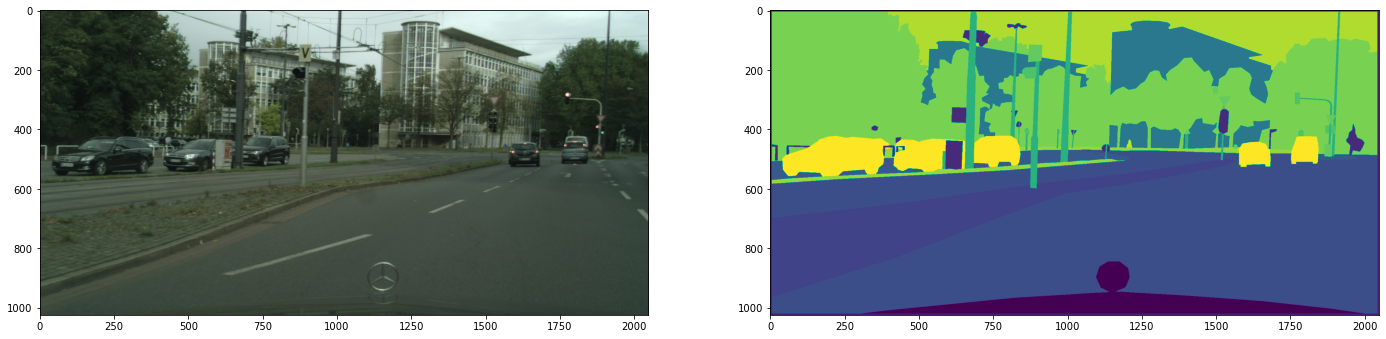

In [3]:
pil_to_tensor = transforms.Compose(
    [ # https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb#scrollTo=-BvRk8ONb00G
        #lambda x: np.array(x),
        transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
    #     std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ]
)

# The Cityscapes tataset is avaliable in PyTorch
train_dataset = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='train', mode='fine', target_type='semantic', transform=pil_to_tensor, target_transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='test',  mode='fine', target_type='semantic', transform=pil_to_tensor, target_transform=transforms.ToTensor())
val_dataset   = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='val',   mode='fine', target_type='semantic', transform=pil_to_tensor, target_transform=transforms.ToTensor())

workers = 5
# Splitting the training and testing datasets into smaller batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)#,  num_workers=workers)#, pin_memory=True))
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)#, num_workers=workers)#, pin_memory=True))

#classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Checking a data sample 
# example = iter(test_loader)
# images, labels = example.next()

# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.axis("off")
#     plt.show()
# imshow(torchvision.utils.make_grid(images))
fig, ax = plt.subplots(ncols=2, figsize=(24, 16))
ax[0].imshow(train_dataset[7][0].numpy().transpose(1,2,0)) # transpose(1,2,0) changes the order of the dimensions
ax[1].imshow(train_dataset[7][1].numpy().transpose(1,2,0))

In [13]:
# Loading the saved model
model = fcn.fcn_resnet50(pretrained=False, progress=True, num_classes=30, aux_loss=False, pretrained_backbone=True).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08)

loaded_checkpoint = torch.load("checkpoint_resnet50_15epochs_cityscapes.pth")
epoch = loaded_checkpoint["epoch"]

# for param in model.parameters():    # Freezing the startign layers
#     # param.requires_grad = False
#     param.requires_grad = False

model.load_state_dict(loaded_checkpoint["model_state"])
optimiser.load_state_dict(loaded_checkpoint["optimiser_state"])
criterion = nn.CrossEntropyLoss()

In [3]:
# batch_iterator = iter(train_loader)
# current_batch = next(batch_iterator)
# image, target = current_batch
# plt.imshow(image[1].numpy().transpose(1,2,0))

In [4]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading the model
model = fcn.fcn_resnet50(pretrained=False, progress=True, num_classes=30, aux_loss=False, pretrained_backbone=True).to(device)

#summary(model, (3, 2048, 1024), batch_size=2)
#model.fc = nn.Linear(512, num_classes).to(device)

#model = nn.DataParallel(model)
#model.to(device)

#num_features = model.features     # Getting the number of features going into the fully connected layer

# Finetuning
# for param in model.parameters():    # Freezing/unfreezing the starting layers
#     # param.requires_grad = False
#     param.requires_grad = False

#model.fc = nn.Linear(len(num_features), 10)  # Redefining the layer with the same input features, but new output features (the amount of classes that we need to classify)
#model.to(device)

#summary(model, (3, 32, 32))

# IOU can be found at https://www.kaggle.com/code/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy/script

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08) # Comment this if a model is loaded

print('Train Size   : ', len(train_dataset))
print('Test Size    : ', len(test_dataset))
print('Val Size     : ', len(val_dataset))
#summary(model, (3, 2048, 1024))


Train Size   :  2975
Test Size    :  1525
Val Size     :  500


In [5]:
# images, targets = next(iter(train_loader))
# print(targets.shape)
# images = images.to(device)

# output = model(images)['out']
# print('Output shape:', output.shape)
# softmax = nn.Softmax(dim=1)
# softmax_output = softmax(output)
#print('Output shape:', softmax_output.shape)

In [14]:
# Training

# Tensorboard
#writer1.add_graph(model, images)
#writer1.close()

# Doing the training now

running_loss = 0
running_correct = 0
#running_loss_test = 0

n_total_steps = len(train_loader)

steps_until_print = batch_size
#print(f'One batch has {len(example)/batch_size} images\nPrint every {steps_until_print}')

# stop_training = False
# def sigint_handler(sig, frame):
#      stop_training = True

# signal.signal(signal.SIGINT, sigint_handler)


model.train()
for epoch in range(num_epochs):
    # if stop_training: break

    # Check for stop - read file for boolean to stopping safely
    with open("train.json") as train_json:
        train_dict = json.load(train_json)
        if train_dict["train"] == "False": break

    testing_batches = iter(test_loader) # Every epoch tests the whole dataset once

    for i, (images, targets) in enumerate(train_loader):
            # Check for stop - read file for boolean to stopping safely
        with open("train.json") as train_json:
            train_dict = json.load(train_json)
            if train_dict["train"] == "False": break

        # images = images_and_targets[i][0].to(device)
        # targets = images_and_targets[i][1].to(device)
        images = images.to(device)
        # print('images shape : ',images.shape)
        # print('targets shape:',targets.shape)
        targets = targets.to(device)

        # Forward pass
        #print("Inputs:", images.shape) 
        outputs = model(images)['out']
        # print("outputs shape:", outputs.shape)
        targets_sq = targets.squeeze(1)
        #print(f'targets:    {torch.unique(targets)}\ntargets_sq: {torch.unique(targets_sq)}')
        #print(f'targets:    {targets.shape}\ntargets_sq: {targets_sq.shape}')
        #loss = criterion(outputs, targets_sq.long())
        loss = criterion(outputs, targets_sq.long())

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights (these are the model parameters(), different from hyperparameters)

        with torch.no_grad():
            # Add loss to the running loss 
            running_loss = loss.item()
            #_, predictions = torch.max(outputs, 1)                  # Evaluate along the 1st dimension

            #running_correct = (predictions == targets).sum().item()  # We can call .item() as it's a tensor with one item

            if (i+1) % 1 == 0: # Maybe replace 1 with steps_until_print
                # Logging the loss
                writer1.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
                
                # Adding the accuracy
                #writer1.add_scalar('Accuracy/training', running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

            # If for every 5 batches, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_targets = testing_batches.next()
                
                test_images = test_images.to(device)
                test_targets = test_targets.squeeze(1).to(device)

                test_outputs = model(test_images)['out']

                # _, test_predictions = torch.max(test_outputs, 1)
                # test_running_correct = (test_predictions == test_targets).sum().item()
                # writer1.add_scalar('Accuracy/testing', test_running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                test_loss = criterion(test_outputs, test_targets.long())
                test_running_loss = test_loss.item()
                writer1.add_scalar('Loss/testing', test_running_loss/len(test_targets), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step
                
        print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
    #writer2.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps) # label of the scalar, actual loss mean, current global step
    #print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
    #print(f'Finished epoch {epoch+1}/{num_epochs}')

print("Training is done")
#AppKit.NSBeep()



Epoch 1/12, step 1/1488, loss = 1.30871
Epoch 1/12, step 2/1488, loss = 1.22528
Epoch 1/12, step 3/1488, loss = 1.22341
Epoch 1/12, step 4/1488, loss = 1.23491
Epoch 1/12, step 5/1488, loss = 1.20067
Epoch 1/12, step 6/1488, loss = 1.27435
Epoch 1/12, step 7/1488, loss = 1.22092
Epoch 1/12, step 8/1488, loss = 1.23987
Epoch 1/12, step 9/1488, loss = 1.24644
Epoch 1/12, step 10/1488, loss = 1.21677
Epoch 1/12, step 11/1488, loss = 1.19616
Epoch 1/12, step 12/1488, loss = 1.18401
Epoch 1/12, step 13/1488, loss = 1.27248
Epoch 1/12, step 14/1488, loss = 1.16366
Epoch 1/12, step 15/1488, loss = 1.24201
Epoch 1/12, step 16/1488, loss = 1.18153
Epoch 1/12, step 17/1488, loss = 1.14887
Epoch 1/12, step 18/1488, loss = 1.15468
Epoch 1/12, step 19/1488, loss = 1.18735
Epoch 1/12, step 20/1488, loss = 1.19935
Epoch 1/12, step 21/1488, loss = 1.19337
Epoch 1/12, step 22/1488, loss = 1.14749
Epoch 1/12, step 23/1488, loss = 1.15637
Epoch 1/12, step 24/1488, loss = 1.17598
Epoch 1/12, step 25/1488,

In [32]:
# Saving the model
# checkpoint = {
#     "epoch": epoch,
#     "model_state": model.state_dict(),
#     "optimiser_state": optimiser.state_dict()
# }
# torch.save(checkpoint, "checkpoint_resnet50_368batches_cityscapes.pth")

#print(optimiser.state_dict())

In [33]:
# Loading the saved model
model = fcn.fcn_resnet50(pretrained=False, progress=True, num_classes=30, aux_loss=False, pretrained_backbone=True).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08)

loaded_checkpoint = torch.load("checkpoint_resnet50_0.00083_cityscapes.pth")
epoch = loaded_checkpoint["epoch"]

# for param in model.parameters():    # Freezing the startign layers
#     # param.requires_grad = False
#     param.requires_grad = False

model.load_state_dict(loaded_checkpoint["model_state"])
optimiser.load_state_dict(loaded_checkpoint["optimiser_state"])

In [6]:
iterator = iter(train_loader)

images, targets = next(iterator)
images, targets = next(iterator)
images = images.to(device)

model.eval()
output = model(images)['out']
print('Output shape:', output.shape)
#softmax = nn.Softmax(dim=1)
##softmax_output = softmax(output)
#print('Output shape:', softmax_output.shape)
#softmax_output

Output shape: torch.Size([2, 30, 1024, 2048])


In [7]:
images, targets = next(iterator)
images = images.to(device)

model.eval()
with torch.no_grad():
    output = model(images)['out']

In [8]:
with torch.no_grad():
    output = model(images)['out']
print(output.shape)
#output.squeeze() [1, 800:805, 700:705]

torch.Size([2, 30, 1024, 2048])


In [9]:
with torch.no_grad():
    print('Output shape:          ', output.shape)
    #output_encoded = output.argmax(dim=1)
    #output_argmax = torch.argmax(output[0], dim=0)
    #output_argmax = torch.max(output, dim=1)
    softmax = nn.Softmax(dim=1)
    output_softmax = softmax(output)
    print('Softmax Output shape:  ', output_softmax.shape)
    output_max, pred = torch.max(output_softmax, dim=1)
    print('Max Output shape:  ', output_max.shape)

Output shape:           torch.Size([2, 30, 1024, 2048])
Softmax Output shape:   torch.Size([2, 30, 1024, 2048])
Max Output shape:   torch.Size([2, 1024, 2048])


In [10]:
with torch.no_grad():
    print(output_softmax[500:510, 300:310])
    #print(torch.unique(output_softmax))

tensor([], device='cuda:0', size=(0, 0, 1024, 2048))


In [11]:
images = images.to('cpu')
targets = targets.to('cpu')
output = output.to('cpu')
pred = output_max.to('cpu')
print(images[0].shape)
print(targets.shape)
print(output[0].shape)
print(output_max[0].shape)

torch.Size([3, 1024, 2048])
torch.Size([2, 1, 1024, 2048])
torch.Size([30, 1024, 2048])
torch.Size([1024, 2048])


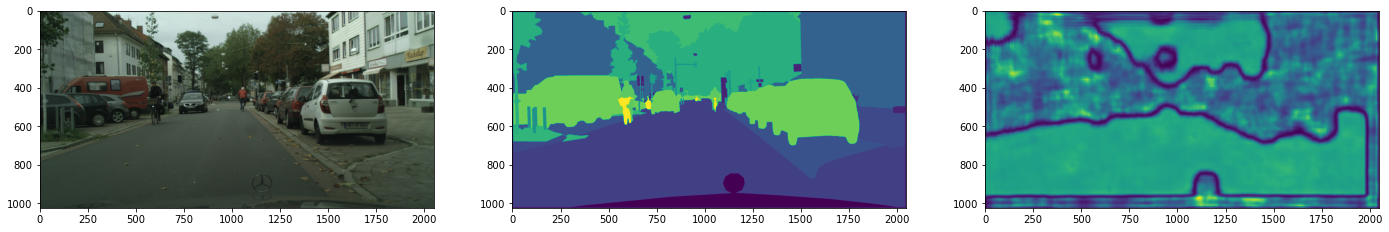

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
ax[0].imshow(images[0].squeeze().permute(1,2,0))  # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[1].imshow(targets[0].squeeze()) # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[2].imshow(pred[0].cpu())

torch.Size([1, 30, 1024, 2048])
Output shape:           torch.Size([1, 30, 1024, 2048])
Softmax Output shape:   torch.Size([1, 30, 1024, 2048])
Max Output shape:   torch.Size([1, 1024, 2048])
torch.Size([3, 1024, 2048])
torch.Size([1, 1, 1024, 2048])
torch.Size([30, 1024, 2048])
torch.Size([1024, 2048])


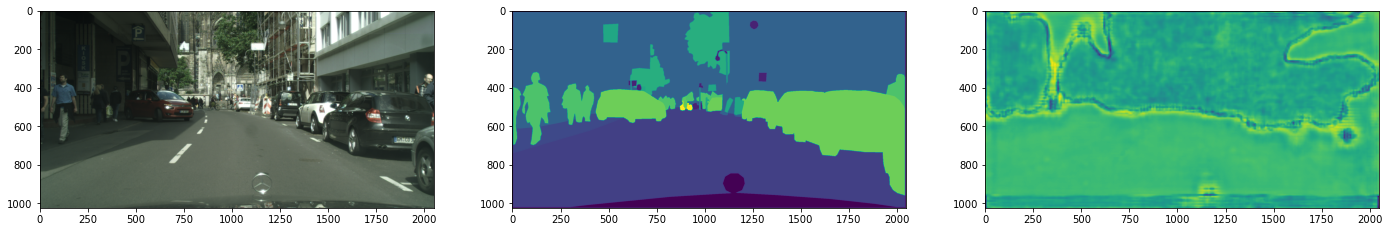

In [31]:
#images, targets = next(iterator)
images = images.to(device)
model.eval()
model.to(device)
#output = model(images)['out']
with torch.no_grad():
    output = model(images.to(device))['out']
print(output.shape)

with torch.no_grad():
    print('Output shape:          ', output.shape)
    #output_encoded = output.argmax(dim=1)
    #output_argmax = torch.argmax(output[0], dim=0)
    #output_argmax = torch.max(output, dim=1)
    softmax = nn.Softmax(dim=1)
    output_softmax = softmax(output)
    print('Softmax Output shape:  ', output_softmax.shape)
    output_max, pred = torch.max(output_softmax, dim=1)
    print('Max Output shape:  ', output_max.shape)

images = images.to('cpu')
targets = targets.to('cpu')
output = output.to('cpu')
pred = output_max.to('cpu')
print(images[0].shape)
print(targets.shape)
print(output[0].shape)
print(output_max[0].shape)
fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
ax[0].imshow(images[0].squeeze().permute(1,2,0))  # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[1].imshow(targets[0].squeeze()) # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[2].imshow(pred.squeeze().cpu())

torch.Size([1, 30, 1024, 2048])
Output shape:           torch.Size([1, 30, 1024, 2048])
Softmax Output shape:   torch.Size([1, 30, 1024, 2048])
Max Output shape:   torch.Size([1, 1024, 2048])
torch.Size([3, 1024, 2048])
torch.Size([1, 1, 1024, 2048])
torch.Size([30, 1024, 2048])
torch.Size([1024, 2048])


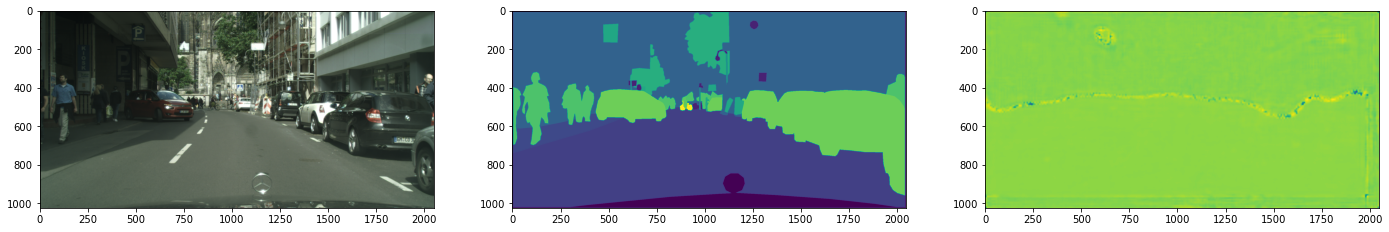

In [34]:
#images, targets = next(iterator)
images = images.to(device)
model.eval()
model.to(device)
#output = model(images)['out']
with torch.no_grad():
    output = model(images.to(device))['out']
print(output.shape)

with torch.no_grad():
    print('Output shape:          ', output.shape)
    #output_encoded = output.argmax(dim=1)
    #output_argmax = torch.argmax(output[0], dim=0)
    #output_argmax = torch.max(output, dim=1)
    softmax = nn.Softmax(dim=1)
    output_softmax = softmax(output)
    print('Softmax Output shape:  ', output_softmax.shape)
    output_max, pred = torch.max(output_softmax, dim=1)
    print('Max Output shape:  ', output_max.shape)

images = images.to('cpu')
targets = targets.to('cpu')
output = output.to('cpu')
pred = output_max.to('cpu')
print(images[0].shape)
print(targets.shape)
print(output[0].shape)
print(output_max[0].shape)
fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
ax[0].imshow(images[0].squeeze().permute(1,2,0))  # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[1].imshow(targets[0].squeeze()) # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[2].imshow(pred.squeeze().cpu())

torch.Size([2, 30, 1024, 2048])
Output shape:           torch.Size([2, 30, 1024, 2048])
Softmax Output shape:   torch.Size([2, 30, 1024, 2048])
Max Output shape:   torch.Size([2, 1024, 2048])
torch.Size([3, 1024, 2048])
torch.Size([2, 1, 1024, 2048])
torch.Size([30, 1024, 2048])
torch.Size([1024, 2048])


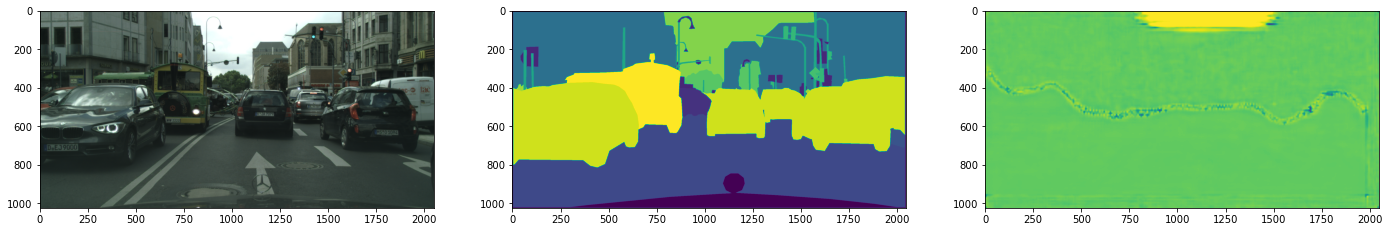

In [16]:
#images, targets = next(iterator)
images = images.to(device)
model.eval()
model.to(device)
#output = model(images)['out']
with torch.no_grad():
    output = model(images.to(device))['out']
print(output.shape)

with torch.no_grad():
    print('Output shape:          ', output.shape)
    #output_encoded = output.argmax(dim=1)
    #output_argmax = torch.argmax(output[0], dim=0)
    #output_argmax = torch.max(output, dim=1)
    softmax = nn.Softmax(dim=1)
    output_softmax = softmax(output)
    print('Softmax Output shape:  ', output_softmax.shape)
    output_max, pred = torch.max(output_softmax, dim=1)
    print('Max Output shape:  ', output_max.shape)

images = images.to('cpu')
targets = targets.to('cpu')
output = output.to('cpu')
pred = output_max.to('cpu')
print(images[0].shape)
print(targets.shape)
print(output[0].shape)
print(output_max[0].shape)
fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
ax[0].imshow(images[0].squeeze().permute(1,2,0))  # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[1].imshow(targets[0].squeeze()) # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
ax[2].imshow(pred[0].cpu())

In [ ]:
#torch.set_printoptions(edgeitems=2200)
#output.squeeze()
#set(*targets[0][:,:,:])
torch.unique(targets[0][:,:,:] / 0.0039)
#targets[0][:, 50, 50]

In [15]:
targets[0].squeeze().shape

torch.Size([1024, 2048])

In [19]:
output_argmax[0][:20,:20]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [13]:
targets.squeeze(1
).shape

torch.Size([1, 1024, 2048])

In [15]:
while True:
    pass

KeyboardInterrupt: 